In [31]:
from scipy.stats import norm
import numpy as np
def logistic(x, L, k, x0, sigma=None):
    """Logistic function."""
    y = L / (1 + np.exp(-k * (x - x0)))
    if sigma is not None:
        y += norm(0, sigma).rvs(len(x))
    return y

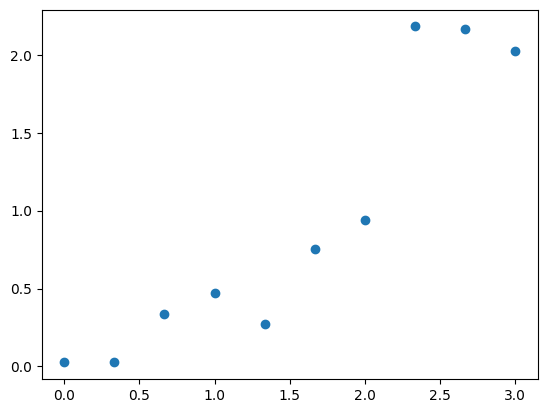

In [32]:
import matplotlib.pyplot as plt
# generate data
n = 10
sigma = 0.3
x = np.linspace(0, 3, n)
L = 10
k = 1
x0 = 4
y = logistic(x, L, k, x0, sigma=sigma)
# plot data
plt.scatter(x, y)

In [33]:
# define priors
L_mean = 10
L_std = 1
k_mean = 1
k_std = 0.3
x0_mean = 4
x0_std = 1



In [34]:
import pandas as pd
# calculate likelihoods and posteriors by sampling from priors
df = pd.DataFrame(columns=['L', 'k', 'x0', 'likelihood', 'posterior'])
n = 10000
# allocate df
df = pd.DataFrame(index=range(n), columns=['L', 'k', 'x0', 'likelihood', 'posterior'])
for i in range(n):
    L_sample = norm(L_mean, L_std).rvs()
    k_sample = norm(k_mean, k_std).rvs()
    x0_sample = norm(x0_mean, x0_std).rvs()
    y_pred = logistic(x, L_sample, k_sample, x0_sample)
    likelihood = norm(y_pred, sigma).pdf(y).prod()
    df.loc[i, 'L'] = L_sample
    df.loc[i, 'k'] = k_sample
    df.loc[i, 'x0'] = x0_sample
    df.loc[i, 'likelihood'] = likelihood

    prior = (norm(L_mean, L_std).pdf(L_sample) *
             norm(k_mean, k_std).pdf(k_sample) *
             norm(x0_mean, x0_std).pdf(x0_sample))
    posterior = prior * likelihood
    df.loc[i, 'posterior'] = posterior
    



In [35]:
# normalize posteriors
df['posterior'] /= df['posterior'].sum()

In [36]:
import numpy as np
# Number of posterior draws to use for interval estimation
n_post_samples = 1000

# x-grid for plotting
x_fit = np.linspace(0, 8, 100)

# Sample parameter sets from the posterior (with replacement, weighted by posterior)
post_samples = df.sample(
    n=n_post_samples,
    replace=True,
    weights='posterior',
    random_state=0
)[['L', 'k', 'x0']].to_numpy()

# For each posterior sample, compute the *mean* curve (no observation noise)
y_samples = np.empty((n_post_samples, len(x_fit)))
for i, (L_s, k_s, x0_s) in enumerate(post_samples):
    y_samples[i, :] = logistic(x_fit, L_s, k_s, x0_s)

# 95% credible band for the mean function
lower_cred = np.percentile(y_samples, 2.5, axis=0)
upper_cred = np.percentile(y_samples, 97.5, axis=0)

In [37]:
# MPE, MLE estimates
# argmax note: ypeError: reduction operation 'argmax' not allowed for this dtype
mpe_idx = df['posterior'].astype(float).idxmax()
mle_idx = df['likelihood'].astype(float).idxmax()
mpe_params = df.loc[mpe_idx, ['L', 'k', 'x0']]
mle_params = df.loc[mle_idx, ['L', 'k', 'x0']]

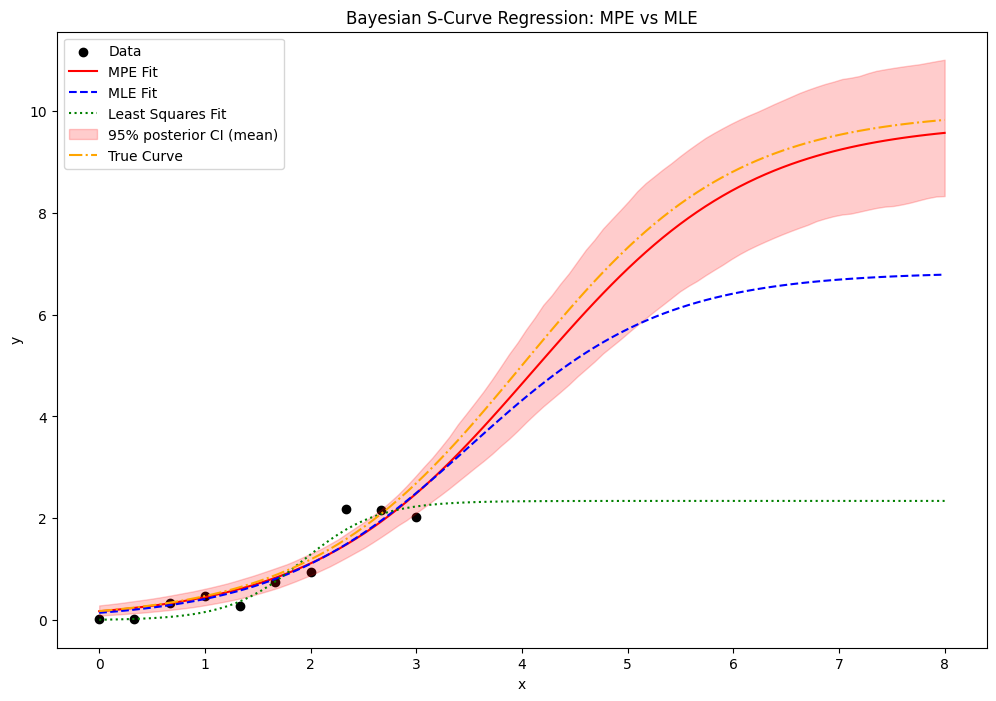

In [38]:
# plot

plt.figure(figsize=(12, 8))
x_fit = np.linspace(0, 8, 100)
y_mpe = logistic(x_fit, mpe_params['L'], mpe_params['k'], mpe_params['x0'])
y_mle = logistic(x_fit, mle_params['L'], mle_params['k'], mle_params['x0'])
plt.scatter(x, y, label='Data', color='black')
plt.plot(x_fit, y_mpe, label='MPE Fit', color='red')
plt.plot(x_fit, y_mle, label='MLE Fit', color='blue', linestyle='--')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Bayesian S-Curve Regression: MPE vs MLE')


# show also least squares fit
from scipy.optimize import curve_fit
popt, _ = curve_fit(lambda x, L, k, x0: L / (1 + np.exp(-k * (x - x0))), x, y, p0=[40, 1, 4])
y_ls = logistic(x_fit, *popt)
plt.plot(x_fit, y_ls, label='Least Squares Fit', color='green', linestyle=':')


# 95% credible band
plt.fill_between(
    x_fit,
    lower_cred,
    upper_cred,
    color='red',
    alpha=0.2,
    label='95% posterior CI (mean)'
)


# plot true
y_true = logistic(x_fit, L, k, x0)
plt.plot(x_fit, y_true, label='True Curve', color='orange', linestyle='-.')
plt.legend()
plt.show()

